In [1]:
#基础工具
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid", palette=sns.color_palette("RdBu", 2))

#使用的模型
from sklearn.linear_model import LogisticRegression as LR

#辅助模块
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.impute import SimpleImputer

### 数据预处理

In [2]:
data = pd.read_csv('train.csv')
data.dropna(axis=0,inplace=True)
data.index = range(data.shape[0])
x = data.iloc[:,1:-1]
y = np.array(data.iloc[:,-1:]).ravel()
test = pd.read_csv('test2.csv')
test.drop(['id_num','is_pass',],axis=1,inplace=True)
test = test.fillna(test.median()) #主要是为了填充age

In [3]:
# 众数填充
# imp_mode = SimpleImputer(strategy = "most_frequent")
# x.loc[:,"program_type"] = imp_mode.fit_transform(x.loc[:,"program_type"].values.reshape(-1,1))
# x.loc[:,"difficulty_level"] = imp_mode.fit_transform(x.loc[:,"difficulty_level"].values.reshape(-1,1))
# x.loc[:,"gender"] = imp_mode.fit_transform(x.loc[:,"gender"].values.reshape(-1,1))
# x.loc[:,"education"] = imp_mode.fit_transform(x.loc[:,"education"].values.reshape(-1,1))
# x.loc[:,"is_handicapped"] = imp_mode.fit_transform(x.loc[:,"is_handicapped"].values.reshape(-1,1))
# x.loc[:,"test_type"] = imp_mode.fit_transform(x.loc[:,"test_type"].values.reshape(-1,1))
# x.loc[:,"program_id"] = imp_mode.fit_transform(x.loc[:,"program_id"].values.reshape(-1,1))

In [4]:
#独热编码
x = pd.get_dummies(x,columns=['program_type','gender','program_id','is_handicapped','test_type'])

In [5]:
newdata = x
newtest = test

#硬编码
newdata.iloc[:] = OrdinalEncoder().fit_transform(newdata.iloc[:])
newtest.iloc[:] = OrdinalEncoder().fit_transform(newtest.iloc[:])

In [6]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25427 entries, 0 to 25426
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   program_duration           25427 non-null  float64
 1   test_id                    25427 non-null  float64
 2   difficulty_level           25427 non-null  float64
 3   trainee_id                 25427 non-null  float64
 4   education                  25427 non-null  float64
 5   city_tier                  25427 non-null  float64
 6   age                        25427 non-null  float64
 7   total_programs_enrolled    25427 non-null  float64
 8   trainee_engagement_rating  25427 non-null  float64
 9   program_type_S             25427 non-null  float64
 10  program_type_T             25427 non-null  float64
 11  program_type_U             25427 non-null  float64
 12  program_type_V             25427 non-null  float64
 13  program_type_X             25427 non-null  flo

### 模型拟合

In [7]:
lrl2 = LR(penalty="l2",solver="liblinear",max_iter=1000)

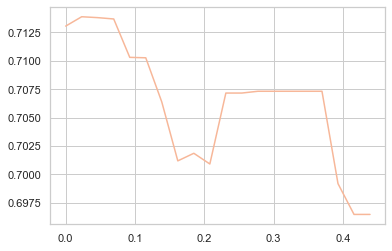

(0.7138867332423129, 0.023111962920424448)

In [8]:
## 运用学习曲线寻找最优的阈值
threshold = np.linspace(0,(lrl2.fit(newdata,y).coef_).max()-0.01,20)
score = []
for i in threshold:
    X_embedded = SelectFromModel(lrl2,threshold=i).fit_transform(newdata,y)
    once = cross_val_score(lrl2,X_embedded,y,cv=5).mean()
    score.append(once)
plt.plot(threshold,score)
plt.show()
# 输出最高的准确率和对应阈值
max(score), threshold[score.index(max(score))]

In [9]:
# 嵌入法选取特征
sfm = SelectFromModel(lrl2,threshold=threshold[score.index(max(score))]).fit(newdata,y)
X_embedded = sfm.transform(newdata)

In [10]:
X_embedded.shape

(25427, 35)

**逻辑回归认为有35个特征是必要的**

In [11]:
## 学习曲线
def plot_learning_curve(estimator,title, X, y,
                        cv=None, #交叉验证
                        ):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            shuffle=True,
                                                            cv=cv,
                                                            random_state=420
                                                            )
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g",label="Test score")
    ax.legend(loc="best")
    return ax

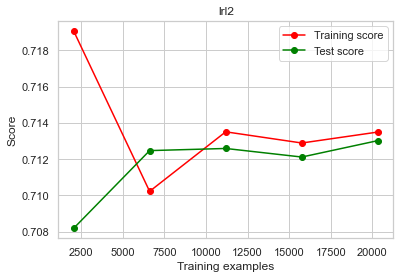

In [12]:
# 查看学习曲线
cv = KFold(n_splits=5, shuffle = True, random_state=42)  #五折交叉验证
plot_learning_curve(lrl2,"lrl2",newdata,y,cv=cv)
plt.show()